# Simple perceptron (C. Mattrand)

This notebook first aims at introducing what is a **simple perceptron** and how does it work based on simple binary classification examples.

The **simple perceptron** was introduced by F. Rosenblatt in 1957 for supervised learning classification purposes. Lets recall that a classifcation algorithm aims at learning how to separate input variables $x$, also named as **features**, given their outputs $y$, also named as **labels**. 

For illustration purpose, we here focus on **binary** classifcation, therefore labels $y$ are either $0$ or $1$, and the number of features is $n=3$ including the bias. We here denote $x=\{1,x_1,x_2\}^t$ the feature vector, including a constant term for taking into account the bias. 

The perceptron maps the input vector $x$ to the output $y$ through the relation $y = o(x^t w)$ where $z = x^t w$ is the weighted sum of the inputs. $w$ is the (synaptic) weight vector and the output activation function is the **heaviside step function**:  $o(z) = step(z) = \left\{\begin{eqnarray} 0 \text{ if } z \leq 0 \\ 1 \text{ if } z>0 \end{eqnarray}\right.$. 

The percetron is composed of the input and output layers only. According to its mathematical formulation, the **simple perceptron** only enables a **linear classification** of labelled training data. It is illustrated hereafter on figure 1.

<div><figure><img src="./../DeepLearning/images/Perceptron.png" width=600 alt="interpretation"/><figcaption><center><b>Figure 1.</b> Simple perceptron for linear binary classificzation</center></figcaption></figure></div>


### Programming the perceptron from scratch

- Definition of the main functions

In [1]:
###### Loading of used librairies ######
import numpy as np
import scipy.stats
import pandas as pds
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

###### Main functions ######
# Heaviside step function
def step(z):
    """
    Heaviside function: transform real values into bynary values (0,1)
    intput: numpy array or dataframe z (weighted sum)
    output: binary numpy array or dataframe y
    """
    y = z
    y[y<=0] = 0
    y[y>0] = 1 
    return y

# Activation function
def activation(z,activation_name):
    """
    Activates or not the signal information from inputs (i.e. the weighted sum of inputs) with more or less strength depending on the type of the function
    intputs: numpy array or dataframe z (weighted sum) ; string activation_name: activation type
    output: numpy array or dataframe y: signal emitted after activation
    """
    if activation_name == "step":
        return step(z)

# Prediction    
def neuron_output_prediction(x,w, activation_name):
    """
    Predicts the signal emitted by the neuron in the output layer
    intputs: numpy array or dataframe x: input layer (row : m instances, columns : n features) including bias, size mxn
             numpy array or dataframe w: weights (synaptic connexions, play the role to transmit the signals from the previous neurons), size (n,)
             string activation_name: select the activation function
    output: numpy array or dataframe y_pred (m,): emitted signal
    """
    z = np.dot(x,w)
    y_pred = activation(z,activation_name)
    return z, y_pred
    
# Initialization function of weights
def weights_initialization(n_features,init_name,value=[]):
    """
    Initilizes the weights
    intputs: float number_features n: number of inputs including bias
             string init_name
             list value: if deterministic values are passed
    output: numpy array w (n,): initialized weigths
    """
    
    if init_name == "deterministe":
        w = np.array(value)
    elif init_name == "zero":
        w = np.zeros((n_features,))
    elif init_name == "random_unif":
        w = scipy.stats.uniform.rvs(loc = -np.sqrt(6/n_features),scale = 2*np.sqrt(6/n_features), size = n_features)
    w[0]=0 # bias is initialized at zero whatever the method used
    return w

# MSE loss function
def mse_loss(y_pred, y):
    """
    Computes the mean squared error loss function
    intputs: numpy array or dataframe y: true observation
             numpy array or dataframe y_pred: predicted observation
            
    output: float error: loss value
    """
    loss = np.mean((y - y_pred)**2)
    return loss  
    
# Training function  
def train(data_train,init_name,activation_name, n_epochs,learning_rate):
    """
    Trains the perceptron/neuron model
    intputs: dataframe data_train: contains the labelled training set
             string intit_name: choice for the method of weights initialization
             string activation_name: choice of the activation function
             n_epochs: number of times the training set is passed for updating the weights
             float learning_rate: allows the determination of the step size bteween updates.
    output: numpy array W: recorded weights at each epoch
            numpy array loss_train: recorded training loss at each step of the algorithm
    """
    x_train = data_train.loc[:,['bias','feature_1','feature_2']] # selection of instances of training features
    y_train = data_train.loc[:,['label']] # selection of instances of training label

    n_features = np.size(x_train,axis=1) # number of features (includes the bias)
    w = weights_initialization(n_features,init_name,value=[]) # initialization of the weights 
    W = np.zeros((n_epochs + 1,n_features)) # creation of a numpy array to save weigths at each epoch of the algorithm
    loss_train = np.zeros((n_epochs+1,))# creation of a numpy array to save the training loss at each epoch of the algorithm
    
    for epoch in range(n_epochs): # iterative update of the weights
        W[epoch, : ] = w
        z, y_pred = neuron_output_prediction(x_train,W[epoch, : ], activation_name) # prediction on train data
        if activation_name == "step":
            w += learning_rate*np.sum(np.tile(y_train.values.squeeze()-y_pred,(n_features,1)).transpose()*x_train.values,axis=0)
        else: # if another differentiable activation function is selected, resort to descent gradient algorithm (here applied to the MSE loss funtion)
            w += learning_rate*np.sum(np.tile((y_train.values.squeeze()-y_pred)*derivative_activation(z,activation_name),(n_features,1)).transpose()*x_train.values, axis=0)
        loss_train[epoch] = mse_loss(y_pred,y_train.values.squeeze()) # computation of loss function
        print("Train, epoch {}: training loss {}, weights{}".format(epoch,loss_train[epoch],W[epoch, : ] ))
    W[epoch+1,:] = w
    z, y_pred = neuron_output_prediction(x_train,W[epoch+1, : ], activation_name)
    loss_train[epoch+1] = mse_loss(y_pred,y_train.values.squeeze())
    return W, loss_train

# Test function
def test(data_test,W,activation_name):
    """
    Tests the perceptron/neuron model
    intputs: dataframe data_test: contains the labelled test set
             numpy array W: weights for which test is required
             string activation_name: choice of the activation function
    output: numpy array loss_tes: recorded test loss for each set of weights
    """
    x_test = data_test.loc[:,['bias','feature_1','feature_2']] # selection of instances of test features
    y_test = data_test.loc[:,['label']] # selection of instances of test label
    nW = np.size(W,axis=0) # number of sets of weights
    loss_test = np.zeros((nW,))# creation of a numpy array to save the test loss
    for j in range(nW):
        z, y_pred = neuron_output_prediction(x_test,W[j,:], activation_name) # prediction on test data
        loss_test[j] = mse_loss(y_pred,y_test.values.squeeze()) # computation of loss function
        print("epoch {}: test loss {}".format(j,loss_test[j]))
    return loss_test
    
    

- Definition of data

**Example #1 : linearly separable data --> data1**

Data are uniformly sampled between $0$ and $1$ and separated by equation: $-0.2 - 0.8x_1 + x_2 = 0$.

In order to study the influence of the number of instances $m$ in this simplest example, the user is free to modify this parameter in the sequel.

,bias,feature_1,feature_2,label
0,1.0,0.417022,0.325810,0.0
1,1.0,0.720324,0.889827,1.0
2,1.0,0.000114,0.751708,1.0
3,1.0,0.302333,0.762632,1.0
4,1.0,0.146756,0.469479,1.0
...,...,...,...,...
995,1.0,0.974403,0.447508,0.0
996,1.0,0.311703,0.184128,0.0
997,1.0,0.668797,0.828733,1.0
998,1.0,0.325967,0.030998,0.0


Text(0.5, 1.0, 'Scatter plot')

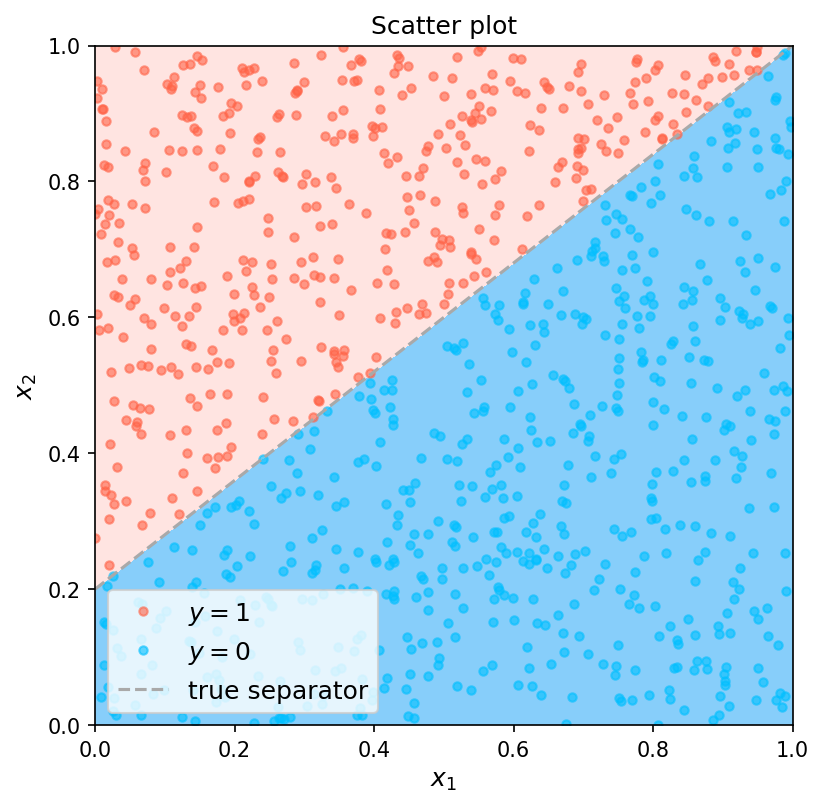

In [2]:
###### Example 1 : linear binary classification ######

m = 1000 # number of instances the user can modify to study the influence on the results.
# generation of data
np.random.seed(1)
x1 = scipy.stats.uniform.rvs(loc = 0, scale = 1,size = m)
x2 = scipy.stats.uniform.rvs(loc = 0, scale = 1, size = m)
y =  -0.2 -0.8*x1 + x2
y[y>0] = 1 # label +1 if y is positive
y[y<=0] = 0 # label 0 otherwise
# creation of dataframe
data1 = pds.DataFrame(columns = ['bias','feature_1','feature_2', 'label']) 
data1.bias = np.ones((m,))
data1.feature_1 = x1
data1.feature_2 = x2
data1.label = y
display(data1) # print the dataframe

# plot of data
fig = plt.figure(figsize=(6,6),dpi=150)
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0., 1.); ax.set_ylim(0., 1.)
ax.plot(x1[y>0],x2[y>0],'o', markersize = 4., mfc = 'tomato', color ='tomato',alpha=0.6, label = '$y = 1$')
ax.plot(x1[y<=0],x2[y<=0],'o', markersize = 4., mfc = 'deepskyblue', color ='deepskyblue',alpha=0.6, label = '$y = 0$')
xx1 = np.linspace(0,1,200)
xx2 = np.linspace(0,1,200)
t1, t2 = np.meshgrid(xx1, xx2)
z = t2 - (0.8*t1 + 0.2)
ax.contourf(t1, t2, z, 1, colors = ['lightskyblue', 'mistyrose'])
tt1= np.linspace(0.,1., 2000)
tt2_1 = 0.8*tt1 + 0.2
plt.plot(tt1,tt2_1,'--',color = 'darkgrey',label = "true separator")
ax.legend(fontsize=12)
ax.set_xlabel("$x_1$",fontsize=12)
ax.set_ylabel("$x_2$",fontsize=12)
plt.title("Scatter plot", fontsize = 12)

**Example #2 : non-linearly separable data --> data2**

Data are uniformly sampled between $0$ and $1$ and separated by equation: $0.4x_2 - (x_1-0.5)^2 = 0$.

In order to study the influence of the number of instances $m$ in this simplest example, the user is free to modify this parameter in the sequel.

,bias,feature_1,feature_2,label
0,1.0,0.417022,0.325810,0.0
1,1.0,0.720324,0.889827,1.0
2,1.0,0.000114,0.751708,1.0
3,1.0,0.302333,0.762632,1.0
4,1.0,0.146756,0.469479,1.0
...,...,...,...,...
995,1.0,0.974403,0.447508,0.0
996,1.0,0.311703,0.184128,0.0
997,1.0,0.668797,0.828733,1.0
998,1.0,0.325967,0.030998,0.0


Text(0.5, 1.0, 'Scatter plot')

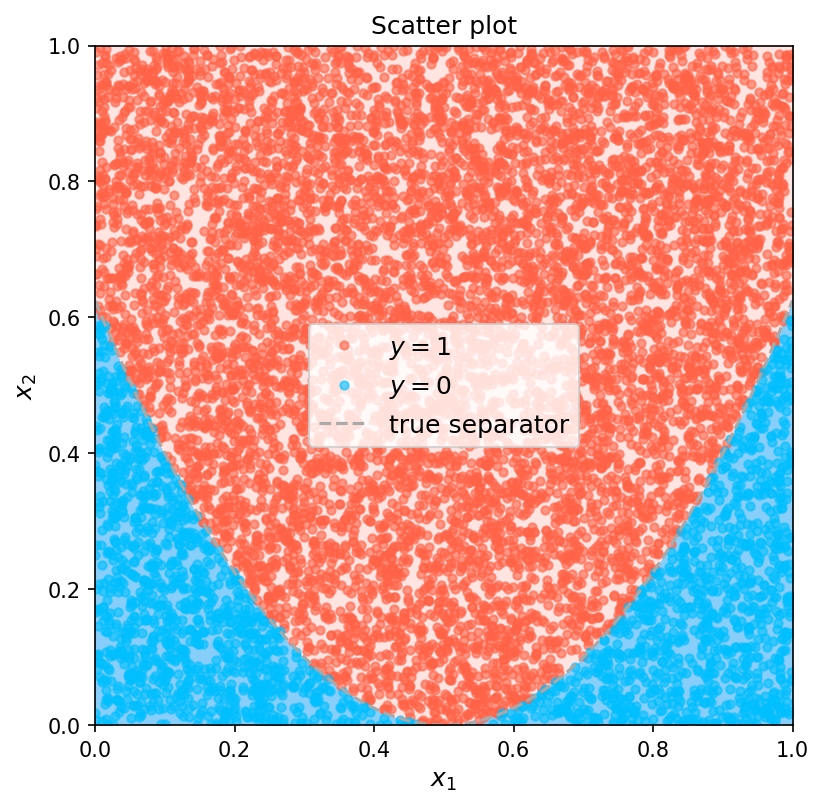

In [3]:
###### Example 2 : non-linear binary classification ######

m = 10000 # number of instances the user can modify to study the influence on the results.
# generation of data
np.random.seed(1)
x1 = scipy.stats.uniform.rvs(loc = 0, scale = 1,size = m)
x2 = scipy.stats.uniform.rvs(loc = 0, scale = 1, size = m)
y =  0.4*x2 - (x1-0.5)**2
y[y>0] = 1 # label +1 if y is positive
y[y<=0] = 0 # label 0 otherwise
# creation of dataframe
data2 = pds.DataFrame(columns = ['bias','feature_1','feature_2', 'label']) 
data2.bias = np.ones((m,))
data2.feature_1 = x1
data2.feature_2 = x2
data2.label = y
display(data1) # print the dataframe

# plot of data
fig = plt.figure(figsize=(6,6),dpi=150)
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0., 1.); ax.set_ylim(0., 1.)
ax.plot(x1[y>0],x2[y>0],'o', markersize = 4., mfc = 'tomato', color ='tomato',alpha=0.6, label = '$y = 1$')
ax.plot(x1[y<=0],x2[y<=0],'o', markersize = 4., mfc = 'deepskyblue', color ='deepskyblue',alpha=0.6, label = '$y = 0$')
xx1 = np.linspace(0,1,200)
xx2 = np.linspace(0,1,200)
t1, t2 = np.meshgrid(xx1, xx2)
z = 0.4*t2 - (t1-0.5)**2
ax.contourf(t1, t2, z, 1, colors = ['lightskyblue', 'mistyrose'])
tt1= np.linspace(0.,1., 2000)
tt2_2 = 2.5*(tt1-0.5)**2
plt.plot(tt1,tt2_2,'--',color = 'darkgrey',label = "true separator")
ax.legend(fontsize=12)
ax.set_xlabel("$x_1$",fontsize=12)
ax.set_ylabel("$x_2$",fontsize=12)
plt.title("Scatter plot", fontsize = 12)

- Splitting of data between train and test sets

$p_{train}$ is used to adjust the percentage of training data : $m_{train} = p_{train} \cdot m$ and therefore $m_{test} = (1-p_{train}) \cdot m$

In [4]:
###### Splitting of data ######
# select which of the example is studied
data_name = "example_1" #"example_2"
if data_name == "example_1":
    data = data1
elif data_name == "example_2":
    data = data2
    
p_train = 0.7 # percentage of data for training
m_train= int(np.round(p_train*m)) # size of the training set
m_test= int(np.round((1-p_train)*m)) # size of the testing set
data_train = data.loc[:m_train-1] #dataframe for training data
data_test = data.loc[m_train:] # dataframe fro testing data

- Training of the classifier and testing on unseen data during learning


Train, epoch 0: training loss 0.579, weights[0.         0.11762695 1.07165358]
Train, epoch 1: training loss 0.421, weights[-57.9        -35.08358209 -19.10609919]
Train, epoch 2: training loss 0.421, weights[-15.8        -20.22433119  12.52738709]
Train, epoch 3: training loss 0.579, weights[26.3        -5.36508028 44.16087337]
Train, epoch 4: training loss 0.421, weights[-31.6        -40.56628933  23.98312061]
Train, epoch 5: training loss 0.51, weights[ 10.5        -25.70703842  55.61660689]
Train, epoch 6: training loss 0.421, weights[-40.5        -55.19332126  36.07347388]
Train, epoch 7: training loss 0.322, weights[  1.6        -40.33407036  67.70696016]
Train, epoch 8: training loss 0.337, weights[-30.6       -58.4170367  52.3936244]
Train, epoch 9: training loss 0.342, weights[  3.1        -44.57914461  76.79156321]
Train, epoch 10: training loss 0.298, weights[-31.1        -63.73180461  60.91665182]
Train, epoch 11: training loss 0.266, weights[ -1.3        -50.79509433  82.2

C:\Users\User\anaconda3\envs\ml-agents\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\User\anaconda3\envs\ml-agents\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'loss function')

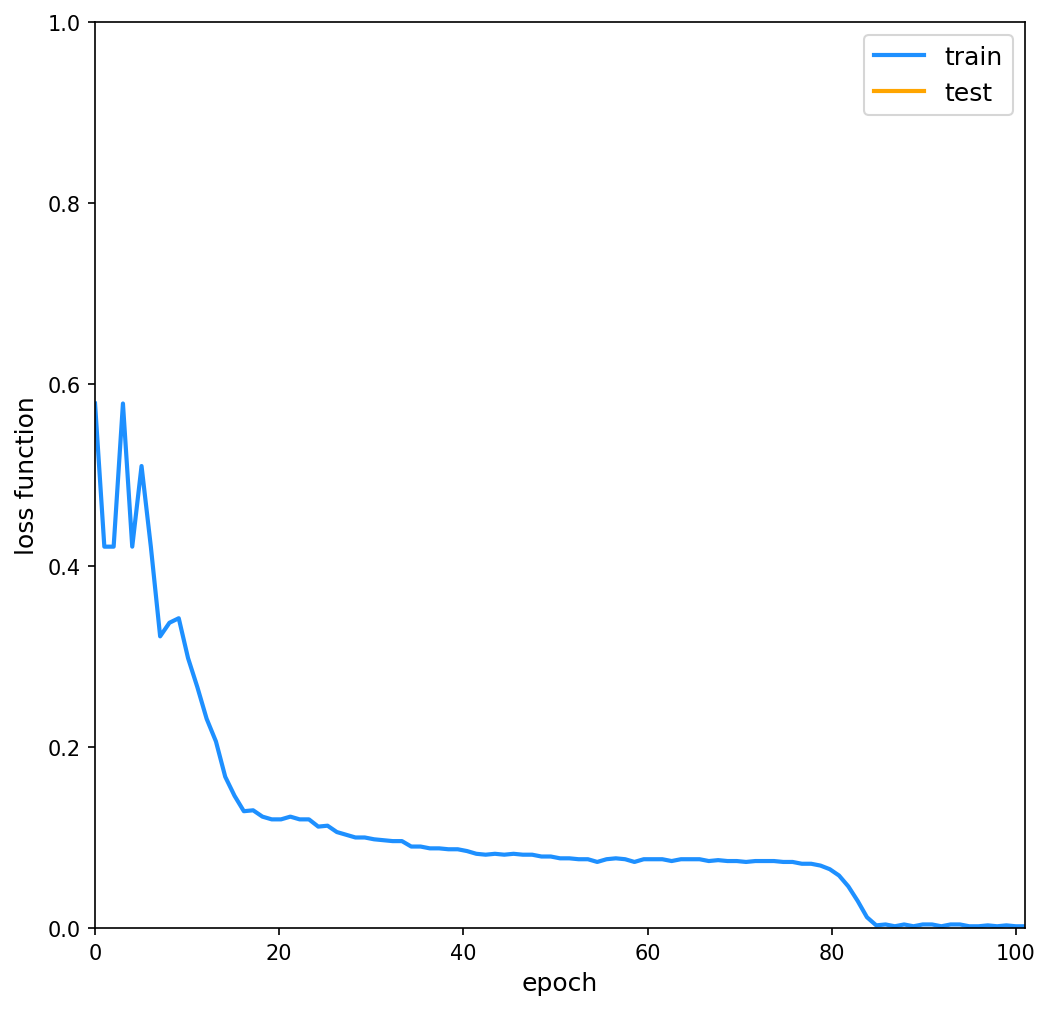

In [5]:
###### Main program ######
# Paramter definition
activation_name = "step" # definition of the activation (no choice here : heaviside step)
init_name="random_unif" # definition of the method for initializing weights
n_epochs = 100 # number of epochs, i.e. iterative steps to update the weights, each epoch use the whole training dataset

# Training of the perceptron
W, loss_train = train(data_train,init_name, activation_name, n_epochs,learning_rate=0.1)
print("The best weight parameters are:{} and leads to a training loss of:{}".format(W[n_epochs,:], loss_train[n_epochs]))

# Testing of the perceptron
loss_test = test(data_test,W,activation_name)

# Plot of the loss functions on training and test sets
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0., n_epochs+1); ax.set_ylim(0., 1.)
ax.plot(np.linspace(0,n_epochs+1,n_epochs+1),loss_train,'-',color = 'dodgerblue', linewidth = 2.0, label = "train")
ax.plot(np.linspace(0,n_epochs+1,n_epochs+1),loss_test,'-',color = 'orange', linewidth = 2.0, label = "test")
ax.legend(fontsize=12)
ax.set_xlabel("epoch",fontsize=12)
ax.set_ylabel("loss function",fontsize=12)

- Plots of data and predicted classes at different epoch

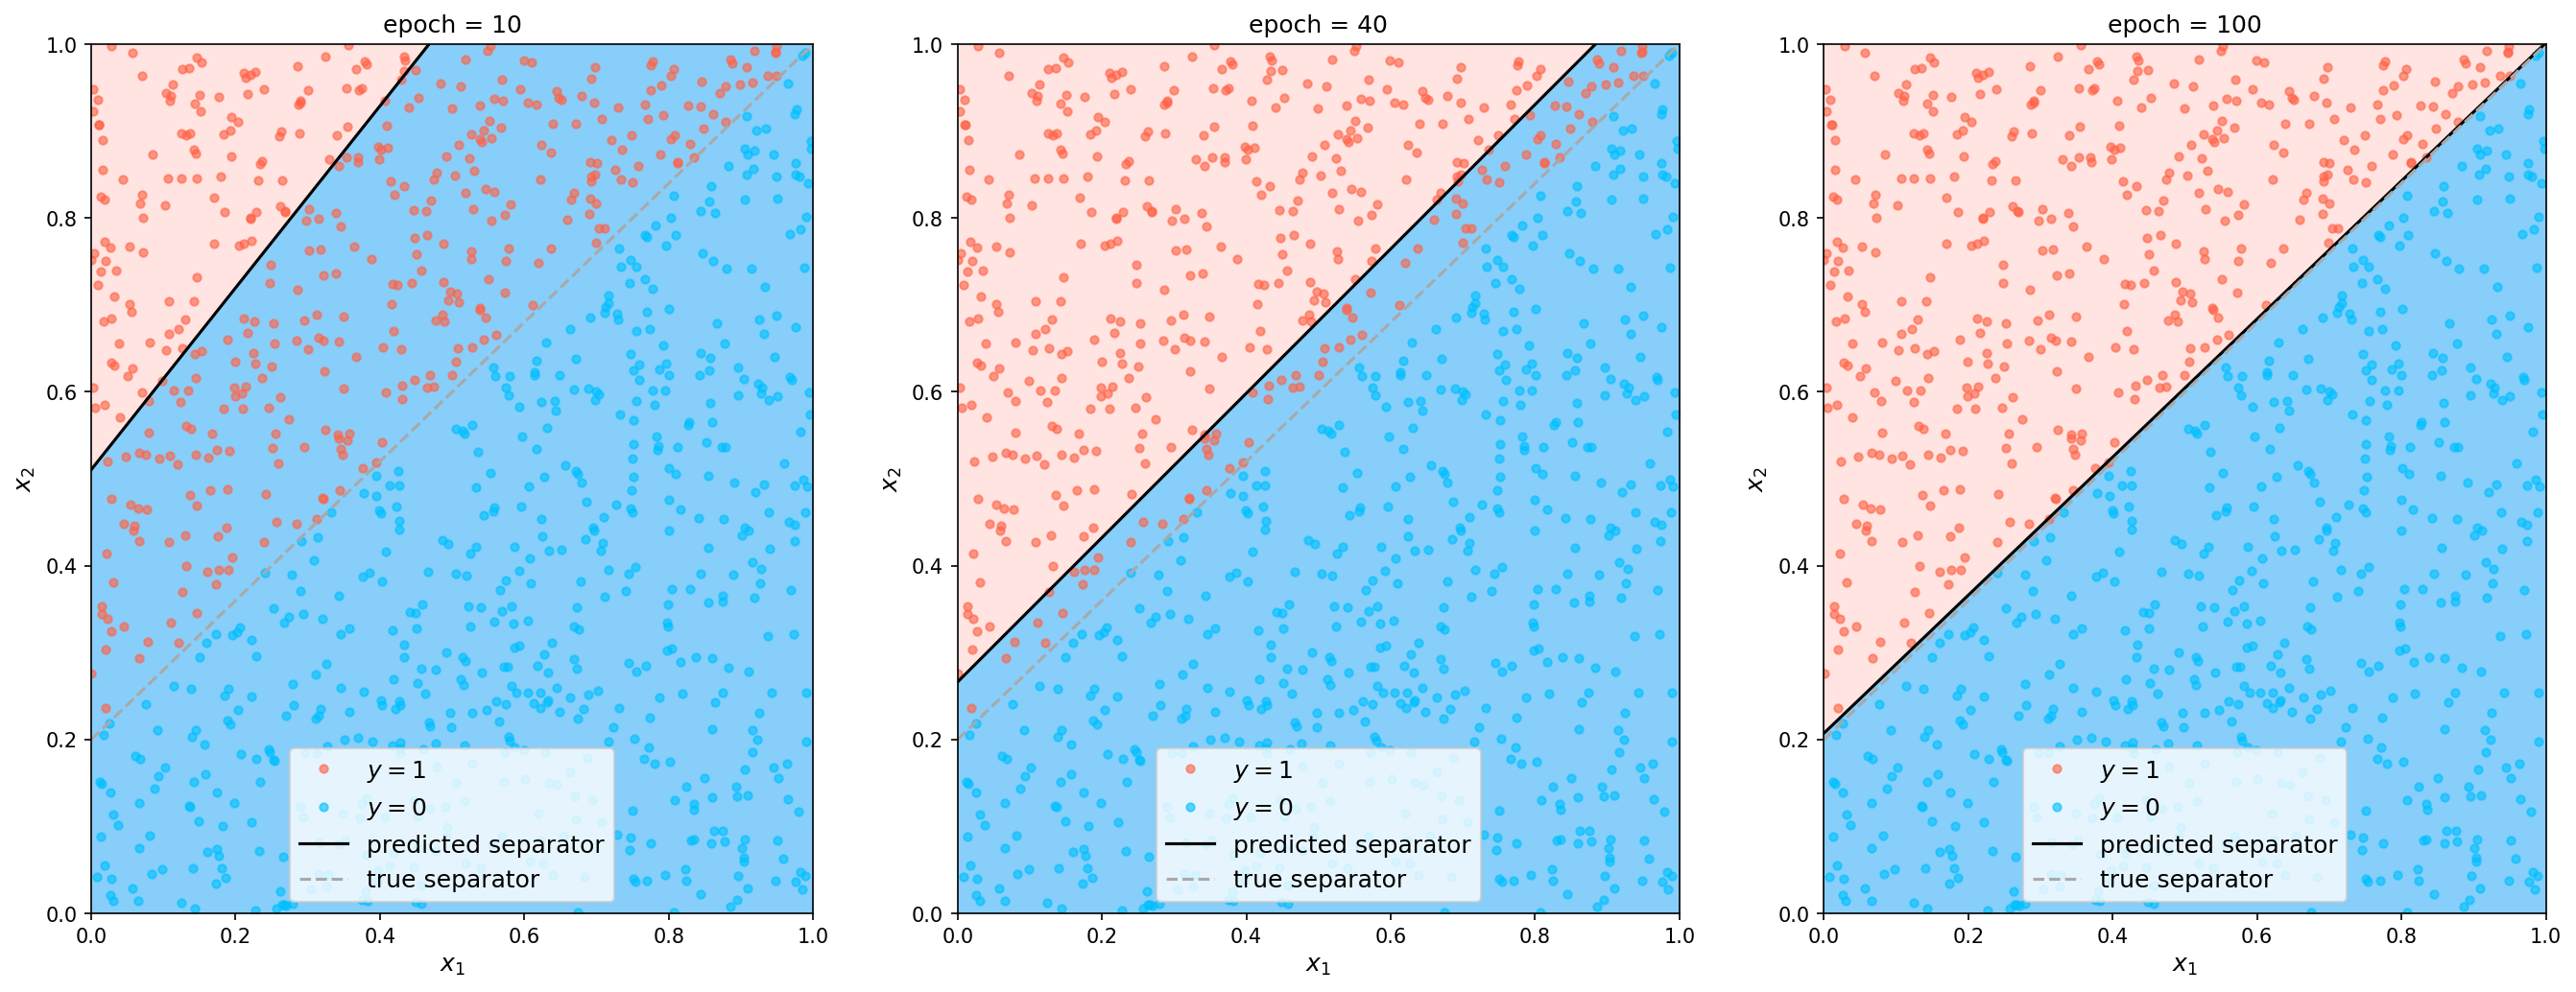

In [6]:
# Visualization of results

fig = plt.figure(figsize=(22,8),dpi=150)

if data_name == "example_1":
    tt2= tt2_1
elif data_name == "example_2":
    tt2 = tt2_2

epoch = [10, 40, n_epochs] # selection of the epoch to be plotted
for i in range(len(epoch)):
    ax = fig.add_subplot(1,len(epoch),i+1)
    ax.set_xlim(0.,1.); ax.set_ylim(0., 1.)
    we = W[epoch[i],:] 
    x1 = data.feature_1.values
    x2 = data.feature_2.values
    y = data.label.values
    ax.plot(x1[y>0],x2[y>0],'o', markersize = 4., mfc = 'tomato', color ='tomato',alpha=0.6,label = "$y = 1$")
    ax.plot(x1[y<=0],x2[y<=0],'o', markersize = 4., mfc = 'deepskyblue', color ='deepskyblue',alpha=0.6, label = "$y = 0$")
    xx1 = np.linspace(0,1,2000)
    xx2 = np.linspace(0,1,2000)
    t1, t2 = np.meshgrid(xx1, xx2)
    z = we[2]*t2 + we[1]*t1 + we[0]
    z[z<=0] = 0
    z[z>0] = 1
    ax.contourf(t1, t2, z, 1, colors = ['lightskyblue', 'mistyrose'])
    tt2_pred = - we[1]/we[2]*tt1 - we[0]/we[2]
    plt.plot(tt1,tt2_pred,'-',color = 'black',label = "predicted separator")
    plt.plot(tt1,tt2,'--',color = 'darkgrey',label = "true separator")
    ax.legend(fontsize=12)
    ax.set_xlabel("$x_1$",fontsize=12)
    ax.set_ylabel("$x_2$",fontsize=12)
    plt.title("epoch = " + str(epoch[i]),fontsize=12)

** Remarks on example 1 : linear classification **

- The perceptron works whatever the number of instances $m = 10, 100, 1000, 10000$ and $p_{train} = 70$%. The training and testing losses decrease with an incresing number of epochs. The difference is null or nearby


- If $p_{train} = 90$% (the number of testing data is small), the test loss function oscillates eratically for a small number $m$ which means the representation set in not consistent, especially for a small number $m$


** Remarks on example 2 : non-linear classification **

- The perceptron fails whatever the number of instances $m = 10, 100, 1000, 10000$ and $p_{train} = 70$%. For $m = 100, 1000, 10000$, the training and testing losses either keep almost constant and noisy whathever the number of epochs (let say $1000$ for example), which means that the complexity of the model is too low --> underfitting siuation with an incresing number of epochs. For $m=10$ the testing loss is zero from the beginning which also the perceptron is not able to learn the data.


- If $p_{train} = 90$% (the number of testing data is small), the test loss function oscillates eratically for a small number $m$ which means the representation set in not consistent, especially for a small number $m$